<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/4_6_SVM_Lecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support Vector Machines (SVM)


In [712]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

We use the Iris dataset

In [713]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer(as_frame=True)
breast_cancer.frame.sample(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
454,12.62,17.15,80.62,492.9,0.08583,0.0543,0.02966,0.02272,0.1799,0.05826,...,22.15,91.62,633.5,0.1225,0.1517,0.1887,0.09851,0.3270,0.07330,1
22,15.34,14.26,102.50,704.4,0.10730,0.2135,0.20770,0.09756,0.2521,0.07032,...,19.08,125.10,980.9,0.1390,0.5954,0.6305,0.23930,0.4667,0.09946,0
566,16.60,28.08,108.30,858.1,0.08455,0.1023,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.1139,0.3094,0.3403,0.14180,0.2218,0.07820,0


In [714]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = breast_cancer.data.iloc[:, :2] # first 2 mean texture, mean radius.
y = breast_cancer.target
y = np.where(y == 0, -1, 1)  # Perceptron: -1 is not malignant.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((455, 2), (114, 2))

## The Perceptron Algorithm

The Perceptron is a simple linear classifier that updates its weights based on misclassified examples. Given a dataset $\mathcal{D} = \{(x^{(n)}, y^{(n)})\}$ where $y^{(n)} \in \{-1, +1\}$, the model predicts:

$$
\hat{y}^{(n)} = \text{sign}(\beta^\top x^{(n)} + \beta_0)
$$

### Weight Update Rule

If $\hat{y}^{(n)} \neq y^{(n)}$, the weights are updated as:

$$
\beta \leftarrow \beta + \eta y^{(n)} x^{(n)}
$$

$$
\beta_0 \leftarrow \beta_0 + \eta y^{(n)}
$$

where $\eta$ is the learning rate.

If $\hat{y}^{(n)} = y^{(n)}$, no update is performed, meaning:

$$
\beta \leftarrow \beta
$$

$$
\beta_0 \leftarrow \beta_0
$$

### Convergence

If the data is linearly separable, the perceptron is guaranteed to converge to a solution. Otherwise, it oscillates indefinitely.


In [715]:
class Perceptron:
    def __init__(self, learning_rate=0.01, max_iters=1000):
        self.lr = learning_rate
        self.max_iters = max_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.max_iters)):
            for idx, x_i in enumerate(X):
                if y[idx] * (np.dot(x_i, self.w) + self.b) <= 0:
                    self.w += self.lr * y[idx] * x_i
                    self.b += self.lr * y[idx]

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

In [716]:
from sklearn.metrics import accuracy_score

perceptron = Perceptron(learning_rate=0.01, max_iters=1000)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy: 89.47%


We plot the decision boundaries between 2 features

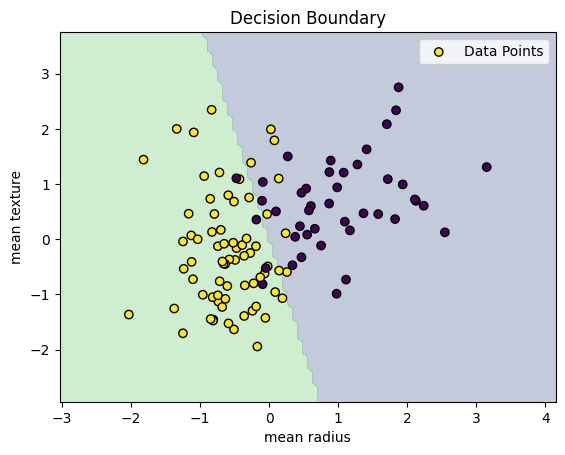

In [717]:
def plot_decision_boundary(X, y, model, feature_indices=(0, 1), feature_names=("Feature 1", "Feature 2")):
    X_selected = X[:, feature_indices]

    x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
    y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    X_grid = np.zeros((xx.ravel().shape[0], X.shape[1]))
    X_grid[:, feature_indices[0]] = xx.ravel()
    X_grid[:, feature_indices[1]] = yy.ravel()

    Z = model.predict(X_grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, levels=np.linspace(Z.min(), Z.max(), 3))
    plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y, edgecolors='k', marker='o', label="Data Points")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Boundary")
    plt.legend()
    plt.show()


plot_decision_boundary(X_test, y_test, model=perceptron, feature_names=breast_cancer.feature_names[:2])

That was easy, here the boundary is linearly serperable.

What if we chose a set that are not?

In [718]:
X = breast_cancer.data.iloc[:, [0,3]]
y = breast_cancer.target
y = np.where(y == 0, -1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((455, 2), (114, 2))

In [719]:
perceptron = Perceptron(learning_rate=0.01, max_iters=1000)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy: 83.33%


An 83% accuracy with a linear decision boundary suggests that mean texture and mean area are not perfectly linearly separable.

Many data points are very close to the decision boundary, and some misclassified points.

Since the data points follow a curved pattern, a linear model cannot fully capture their relationship.

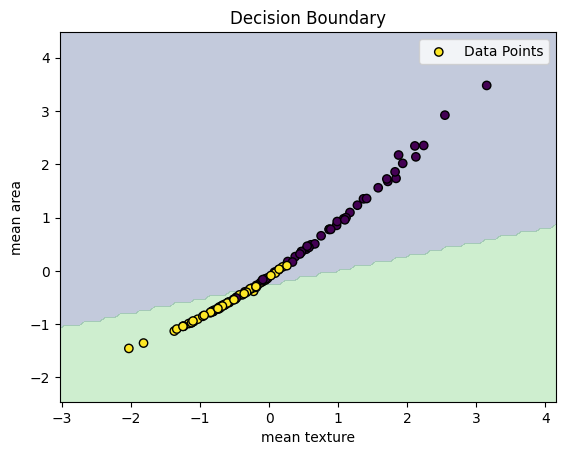

In [720]:
plot_decision_boundary(X_test, y_test, model=perceptron, feature_names=(breast_cancer.feature_names[1], breast_cancer.feature_names[3]))

# SVMs

## Linear SVM

Support Vector Machines (SVMs) extend the perceptron by introducing the concept of maximizing margins. Instead of just finding a separating hyperplane, SVM optimizes for the decision boundary with the widest margin between classes. Given a dataset $\mathcal{D} = \{(x^{(n)}, y^{(n)})\}$ with $y^{(n)} \in \{-1,+1\}$, SVM solves:

$$
\min_{\beta, \beta_0} \frac{1}{2} ||\beta||^2
$$

subject to:

$$
y^{(n)} (\beta^\top x^{(n)} + \beta_0) \geq 1, \quad \forall n
$$

This ensures that all points lie outside the margin. The margin is given by:

$$
M = \frac{2}{||\beta||}
$$

To find the optimal decision boundary, we use **subgradient descent** to minimize the **hinge loss** with **L2 regularization**. The **decision function** determines whether a sample satisfies the margin constraint:

$$
\hat{y}^{(n)} = \text{sign}(\beta^\top x^{(n)} + \beta_0)
$$

- If the current sample **satisfies** the margin constraint $
  y^{(n)} \hat{y}^{(n)} \geq 1$:
  $$
  \beta \leftarrow \beta - \eta (2 \lambda \beta)
  $$

- If the current sample **violates** the margin constraint $
  y^{(n)} \hat{y}^{(n)} < 1$:
  $$
  \beta \leftarrow \beta - \eta (2 \lambda \beta - y^{(n)} x^{(n)})
  $$
  $$
  \beta_0 \leftarrow \beta_0 - \eta y^{(n)}
  $$

where:
- $ \eta $ is the **learning rate**.
- $ \lambda $ is the **regularization parameter** controlling margin maximization.
- $ \beta $ is the **weight vector**, and $ \beta_0 $ is the **bias**.
- The **decision function** $ \hat{y} = \text{sign}(\beta^\top x + \beta_0) $ is used to determine classification.

In [721]:
class SupportVectorMachine:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, max_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.max_iters = max_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.max_iters)):
            margins = y * (X @ self.w + self.b)
            misclassified = margins < 1

            grad_w = 2 * self.lambda_param * self.w - np.mean((misclassified * y)[:, None] * X, axis=0)
            grad_b = -np.mean(misclassified * y)

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

    def predict(self, X):
        return np.sign(X @ self.w + self.b)

In [722]:
X = breast_cancer.data.iloc[:, [0,3]]
y = breast_cancer.target
y = np.where(y == 0, -1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SupportVectorMachine(learning_rate=0.1)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy: 92.98%


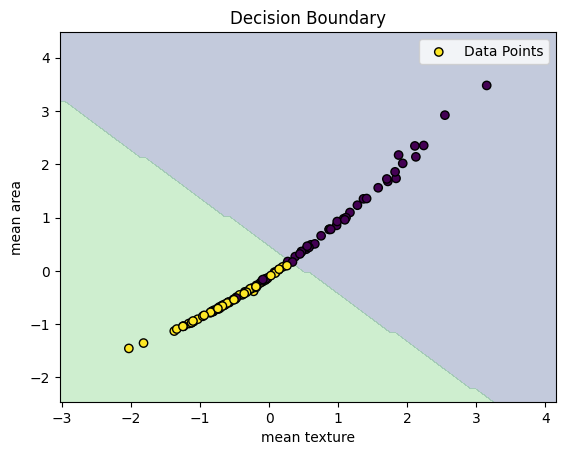

In [723]:
plot_decision_boundary(X_test, y_test, model=svm, feature_names=(breast_cancer.feature_names[1], breast_cancer.feature_names[3]))

## Soft-Margin SVM

Soft-margin SVM allows some misclassification by introducing slack variables $\xi_i$, balancing margin maximization and error minimization. The optimization problem is:

$$
\min_{w, b, \xi} \frac{1}{2} ||w||^2 + C \sum_{i=1}^{n} \xi_i
$$

subject to:

$$
y_i (w^\top x_i + b) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad \forall i
$$

where $C$ controls the trade-off between maximizing the margin and minimizing classification.

In gradient-based optimization, the weight update incorporates slack terms:

$$
w \leftarrow w - \eta \left( 2\lambda w - C \sum_{i \in \mathcal{M}} y_i x_i \right)
$$

$$
b \leftarrow b - \eta \left( -C \sum_{i \in \mathcal{M}} y_i \right)
$$

where $\mathcal{M} = \{i | y_i (w^\top x_i + b) < 1 \}$ are the misclassified points.

In [724]:
class SupportVectorMachineSlack:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, C=1.0, max_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param  # Regularization (λ = 1 / C)
        self.C = C  # Soft-margin trade-off parameter
        self.max_iters = max_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.max_iters)):
            margins = y * (X @ self.w + self.b)
            slack = margins < 1  # Slack variable condition: ξ_i > 0 when margin is violated

            grad_w = 2 * self.lambda_param * self.w - self.C * np.mean((slack * y)[:, None] * X, axis=0)
            grad_b = -self.C * np.mean(slack * y)

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

    def predict(self, X):
        return np.sign(X @ self.w + self.b)


In [725]:
X = breast_cancer.data.iloc[:, [0,3]]
y = breast_cancer.target
y = np.where(y == 0, -1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SupportVectorMachineSlack(learning_rate=0.1, C=1.5)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy: 92.98%


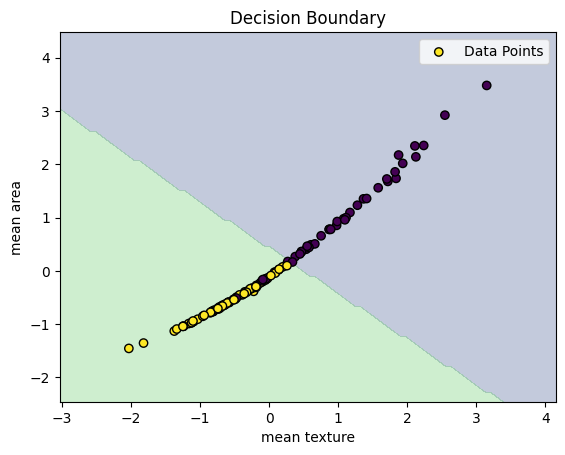

In [726]:
plot_decision_boundary(X_test, y_test, model=svm, feature_names=(breast_cancer.feature_names[1], breast_cancer.feature_names[3]))

## Dual Formulation of Soft-Margin SVM

Support Vector Machines (SVM) optimize a **Lagrangian formulation** to maximize the margin while allowing some misclassification. The dual form is derived from the **Lagrange multipliers**, introducing $\alpha_i$ for each constraint


$$
\max_{\alpha} \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} \alpha_i \alpha_j y_i y_j K(x_i, x_j)
$$

subject to:
$$
0 \leq \alpha_i \leq C, \quad \sum_{i=1}^{n} \alpha_i y_i = 0
$$

where:
- $K(x_i, x_j) = x_i^\top x_j$ for a **linear SVM**.
- The **slack variables** $\xi_i$ in the primal formulation allow soft-margin optimization.


Once $\alpha$ is optimized, the **weight vector** is:
$$
w = \sum_{i=1}^{n} \alpha_i y_i x_i
$$
The **bias term** is computed using support vectors:
$$
b = \frac{1}{|S|} \sum_{i \in S} (y_i - w^\top x_i)
$$
where $S$ is the set of support vectors.


Instead of computing $w$ explicitly, the prediction function is written using the kernel function:
$$
f(x) = \sum_{i=1}^{n} \alpha_i y_i K(x_i, x) + b
$$


In [727]:
import numpy as np

class SupportVectorMachineDual:
    def __init__(self, C=1.0, kernel=None, max_iters=1000, tol=1e-5):
        self.C = C  # Soft-margin trade-off parameter
        self.kernel = kernel if kernel else self.linear_kernel  # Default to linear kernel
        self.max_iters = max_iters  # Maximum iterations
        self.tol = tol  # Convergence tolerance
        self.alpha = None
        self.b = 0
        self.support_vectors = None
        self.support_labels = None
        self.support_alphas = None

    def linear_kernel(self, X1, X2):
        return X1 @ X2.T

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.astype(float)

        # Compute the kernel matrix
        K = self.kernel(X, X)

        # Initialize Lagrange multipliers
        self.alpha = np.zeros(n_samples)

        # Dual form optimization using coordinate ascent
        for _ in tqdm(range(self.max_iters)):
            alpha_prev = np.copy(self.alpha)
            for i in range(n_samples):
                error_i = np.dot((self.alpha * y), K[:, i]) - y[i]

                # Update α with a step size
                self.alpha[i] += self.C * (1 - error_i) * 0.01  # Increased step size
                self.alpha[i] = np.clip(self.alpha[i], 0, self.C)  # Projection



        # Identify support vectors (where α > 1e-5)
        support_vector_indices = (self.alpha > 1e-6)  # Relaxed threshold
        self.support_vectors = X[support_vector_indices]
        self.support_labels = y[support_vector_indices]
        self.support_alphas = self.alpha[support_vector_indices]

        # Fix: Compute bias term only using **active support vectors**
        if len(self.support_vectors) > 0:
            K_sv = self.kernel(self.support_vectors, self.support_vectors)
            self.b = np.mean(
                self.support_labels - np.sum(self.support_alphas * self.support_labels * K_sv, axis=1)
            )
        else:
            self.b = 0  # Default if no support vectors are found

    def predict(self, X):
        K_test = self.kernel(X, self.support_vectors)
        return np.sign(np.sum(self.support_alphas * self.support_labels * K_test, axis=1) + self.b)


In [728]:
X = breast_cancer.data.iloc[:, [0,3]]
y = breast_cancer.target
y = np.where(y == 0, -1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm = SupportVectorMachineDual(C=1.5)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy: 78.95%


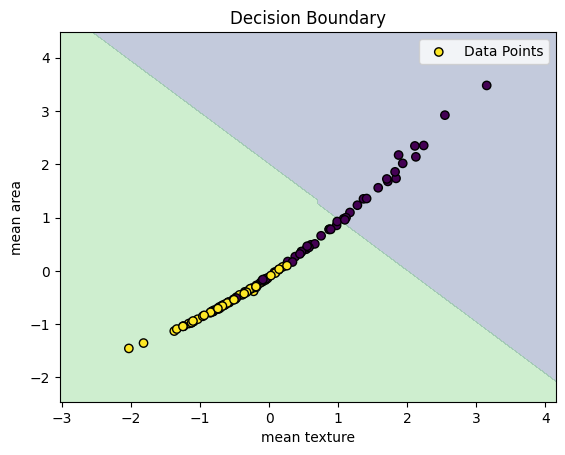

In [729]:
plot_decision_boundary(X_test, y_test, model=svm, feature_names=(breast_cancer.feature_names[1], breast_cancer.feature_names[3]))

## The Kernel Trick in Support Vector Machines (SVM)

Support Vector Machines (SVMs) can handle nonlinear classification problems using the **kernel trick**.


- **Linear Kernel**: Preserves the original feature space.
  
  $$
  K(x, x') = x^\top x'
  $$

- **Polynomial Kernel**: Introduces interactions between features, enabling curved decision boundaries.

  $$
  K(x, x') = (x^\top x' + c)^d
  $$

- **Radial Basis Function (RBF) Kernel**: Maps points into a higher-dimensional space using a Gaussian transformation, allowing flexible decision boundaries.

  $$
  K(x, x') = \exp(-\gamma ||x - x'||^2)
  $$

- **Sigmoid Kernel**: Resembles activation functions in neural networks.

  $$
  K(x, x') = \tanh(\alpha x^\top x' + c)
  $$

Each kernel provides a different way of transforming the data while keeping computations in the dual space

  0%|          | 0/1000 [00:00<?, ?it/s]

Test Accuracy: 78.95%


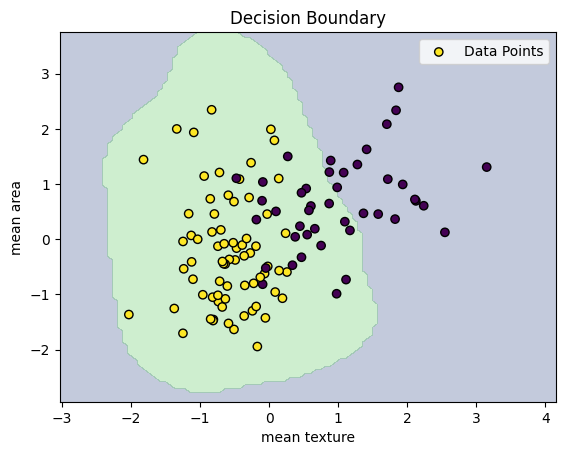

In [730]:
X = breast_cancer.data.iloc[:, [0,1]]
y = breast_cancer.target
y = np.where(y == 0, -1, 1)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RBF kernel
def rbf_kernel(X1, X2, gamma=0.5):
    sq_dist = np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) ** 2
    return np.exp(-gamma * sq_dist)

# Train SVM with RBF kernel
svm_rbf = SupportVectorMachineDual(C=1.2, kernel=lambda X1, X2: rbf_kernel(X1, X2, gamma=1.5))
svm_rbf.fit(X_train, y_train)
y_pred = svm_rbf.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot the decision boundary
plot_decision_boundary(X_test, y_test, model=svm_rbf, feature_names=(breast_cancer.feature_names[1], breast_cancer.feature_names[3]))


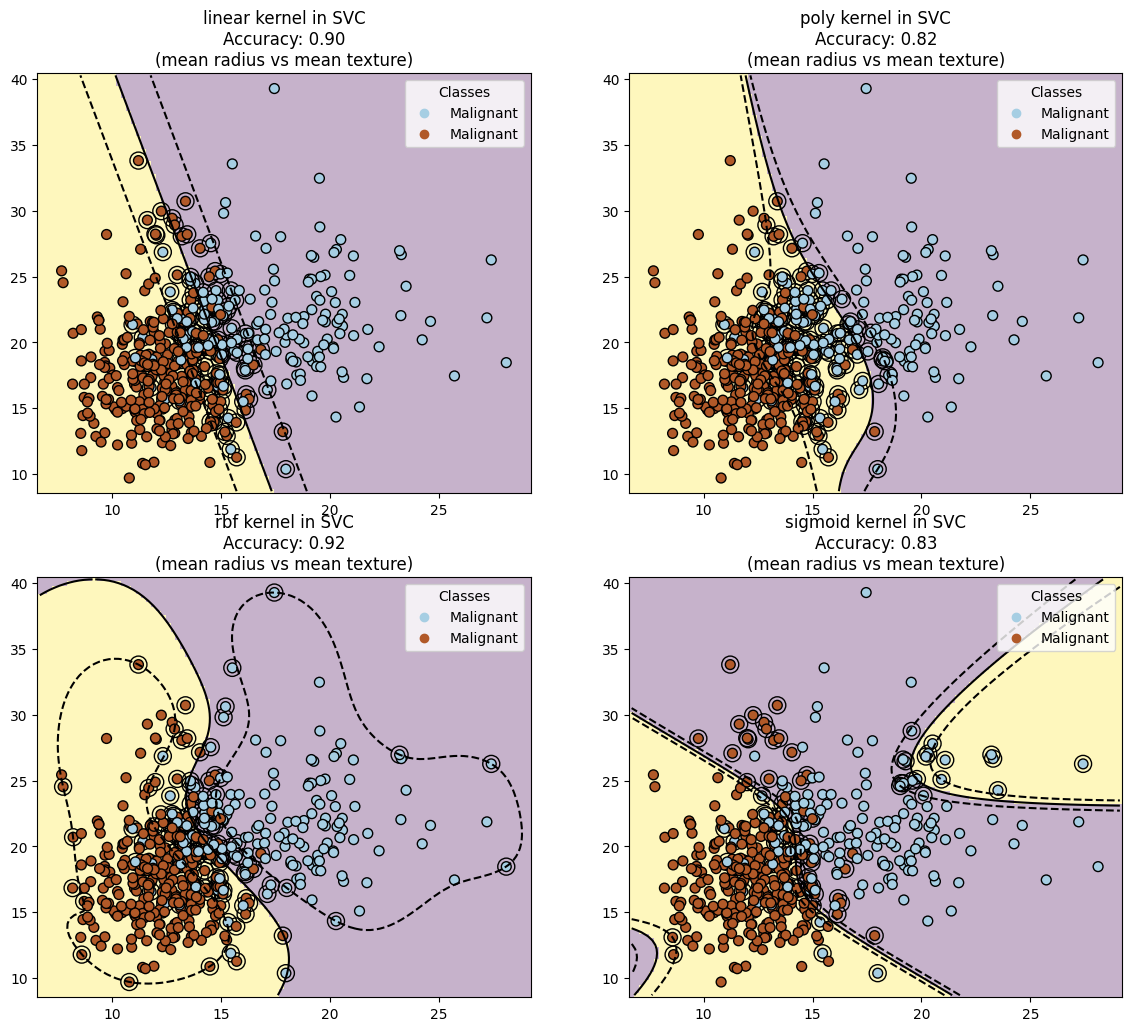

In [731]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

X = breast_cancer.data.iloc[:, [0, 1]]
y = np.where(breast_cancer.target == 0, -1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def plot_svm_decision_boundary(kernel, X_train, y_train, X_test, y_test, ax, feature_names, class_names):
    svc_clf = make_pipeline(StandardScaler(), SVC(kernel=kernel, C=1))
    svc_clf.fit(X_train, y_train)

    X_train = np.array(X_train)

    y_pred = svc_clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    common_params = {"estimator": svc_clf, "X": X_train, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    support_vectors = svc_clf.named_steps['standardscaler'].inverse_transform(
        svc_clf.named_steps['svc'].support_vectors_
    )
    ax.scatter(
        support_vectors[:, 0],
        support_vectors[:, 1],
        s=150,
        facecolors="none",
        edgecolors="k",
        label="Support Vectors",
    )

    scatter = ax.scatter(
        X_train[:, 0],
        X_train[:, 1],
        c=y_train,
        cmap=plt.cm.Paired,
        edgecolors="k",
        s=50,
    )

    legend_labels = [class_names[int(label)] for label in np.unique(y_train)]
    ax.legend(
        scatter.legend_elements()[0],
        legend_labels,
        loc="upper right",
        title="Classes",
    )

    ax.set_title(f"{kernel} kernel in SVC\nAccuracy: {accuracy:.2f}\n({feature_names[0]} vs {feature_names[1]})")

kernels = ["linear", "poly", "rbf", "sigmoid"]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for kernel, ax in zip(kernels, axes.ravel()):
    plot_svm_decision_boundary(kernel, X_train, y_train, X_test, y_test, ax,
                               feature_names=[breast_cancer.feature_names[0], breast_cancer.feature_names[1]],
                               class_names=["Benign", "Malignant"])


# Support Vector Regression (SVR)

Support Vector Regression (SVR) extends Support Vector Machines (SVM) to regression tasks. Instead of finding a maximum margin separator, SVR tries to fit a function $f(\beta)$ that deviates from the true outputs by at most a margin $\epsilon$, while minimizing model complexity. The optimization problem is formulated as:

$
\min_{\beta, b, \xi, \xi^*} \frac{1}{2} ||\beta||^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)
$

subject to:

$
y_i - (\beta^T \beta_i + b) \leq \epsilon + \xi_i
$

$
(\beta^T \beta_i + b) - y_i \leq \epsilon + \xi_i^*
$

$
\xi_i, \xi_i^* \geq 0
$

where:

- $\beta$ represents the weight vector,
- $b$ is the bias term,
- $\xi_i, \xi_i^*$ are slack variables that allow violations of the $\epsilon$-tube,
- $C$ controls the trade-off between model complexity and tolerance for outliers,
- $\epsilon$ defines the margin of tolerance.

In [732]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score

class SupportVectorRegressionDual:
    def __init__(self, C=1.0, epsilon=0.01, tol=1e-3, max_iters=500):
        self.C = C
        self.epsilon = epsilon
        self.tol = tol
        self.max_iters = max_iters
        self.alpha = None
        self.alpha_star = None
        self.b = 0
        self.w = None

    def linear_kernel(self, X1, X2):
        return X1 @ X2.T

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.alpha_star = np.zeros(n_samples)
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in tqdm(range(self.max_iters)):
            for i in range(n_samples):
                error_i = (self.alpha - self.alpha_star) @ self.linear_kernel(X, X[i]) - y[i] + self.b

                if abs(error_i) < self.epsilon:
                    continue

                delta_alpha = self.C * (1 - error_i) * 0.001
                self.alpha[i] = np.clip(self.alpha[i] + delta_alpha, 0, self.C)
                self.alpha_star[i] = np.clip(self.alpha_star[i] - delta_alpha, 0, self.C)

            if np.linalg.norm(self.alpha - self.alpha_star) < self.tol:
                break

        self.w = ((self.alpha - self.alpha_star) @ X)
        support_vector_indices = (self.alpha > 1e-5) | (self.alpha_star > 1e-5)
        self.b = np.mean(y[support_vector_indices] - X[support_vector_indices] @ self.w)

    def predict(self, X):
        return X @ self.w + self.b

data = fetch_california_housing()
X = data.data[:, :2]
y = data.target

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=2000, random_state=42)
svr_linear = SupportVectorRegressionDual(C=0.5, epsilon=0.01)
svr_linear.fit(X_train, y_train)

y_test_pred = svr_linear.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

print(f"Fast Linear SVR - MSE: {mse:.4f}, R²: {r2:.4f}")


  0%|          | 0/500 [00:00<?, ?it/s]

Fast Linear SVR - MSE: 0.4924, R²: 0.5067


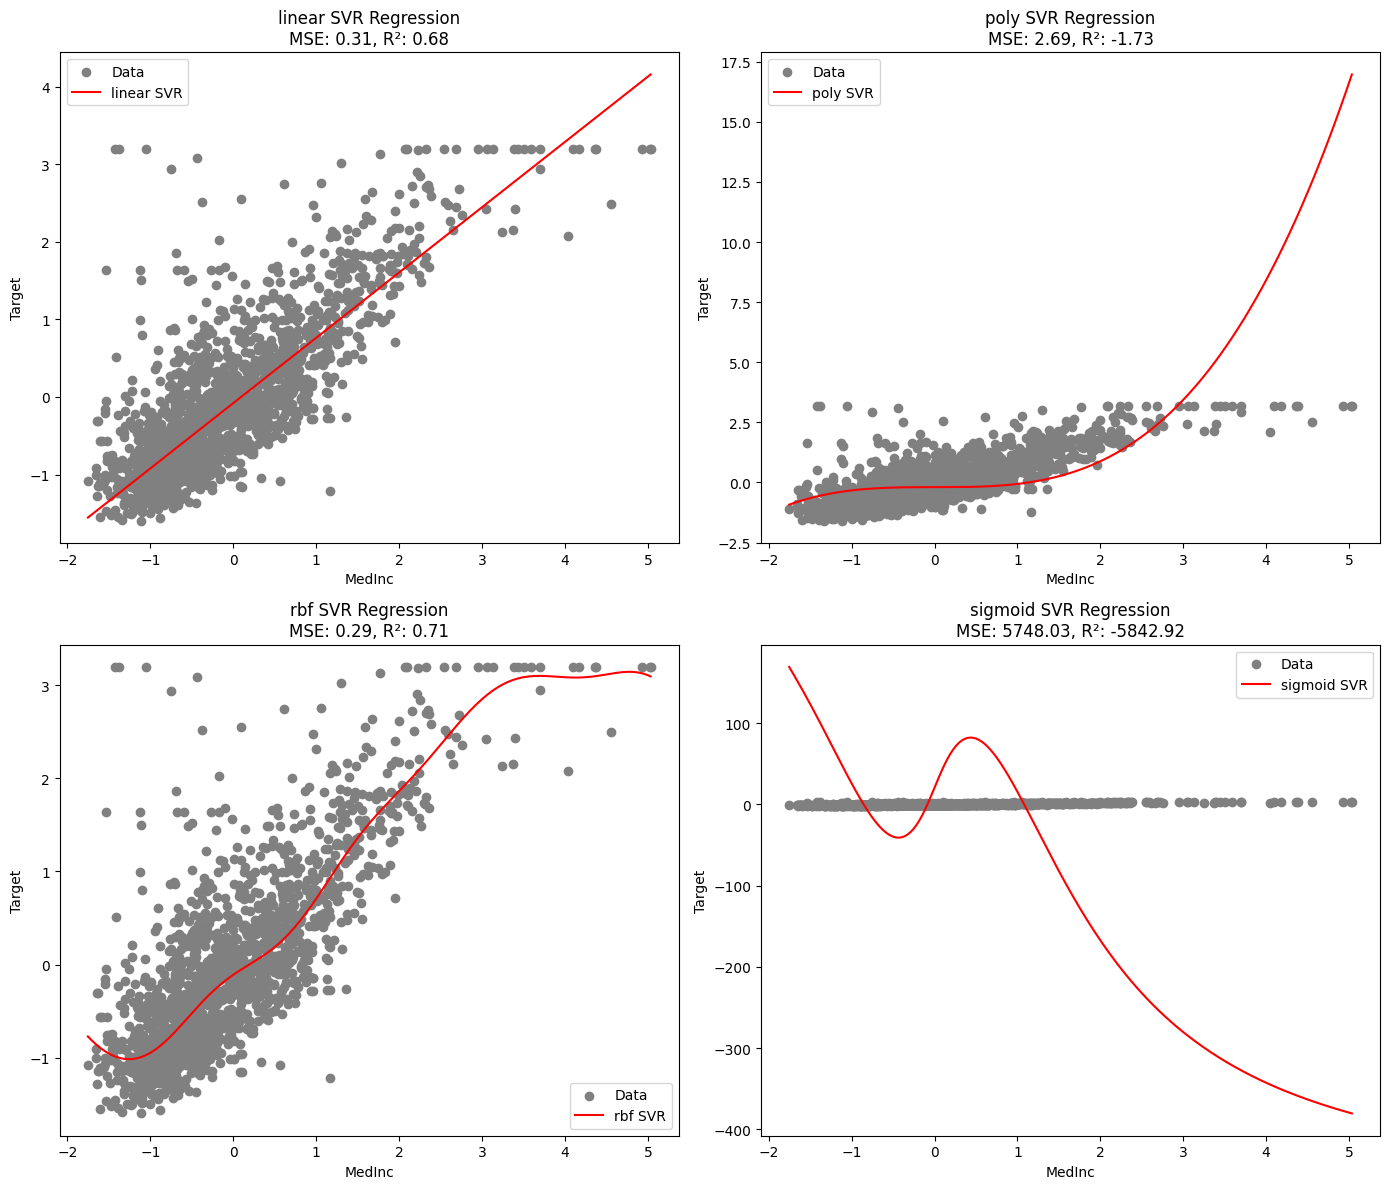

In [733]:
from sklearn.svm import SVR
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, r2_score

data = fetch_california_housing()
X = data.data[:2000, :1]
y = data.target[:2000]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def plot_svr_regression(kernel, X_train, y_train, X_test, y_test, ax, feature_name):
    svr_clf = SVR(kernel=kernel, C=1.0, epsilon=0.1)
    svr_clf.fit(X_train, y_train)

    X_grid = np.linspace(X_train.min(), X_train.max(), 200).reshape(-1, 1)
    y_pred_grid = svr_clf.predict(X_grid)
    y_pred_test = svr_clf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    ax.scatter(X_train, y_train, color="gray", label="Data")
    ax.plot(X_grid, y_pred_grid, color="red", label=f"{kernel} SVR")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Target")
    ax.set_title(f"{kernel} SVR Regression\nMSE: {mse:.2f}, R²: {r2:.2f}")
    ax.legend()

kernels = ["linear", "poly", "rbf", "sigmoid"]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
for kernel, ax in zip(kernels, axes.ravel()):
    plot_svr_regression(kernel, X_train, y_train, X_test, y_test, ax, feature_name=data.feature_names[0])

plt.tight_layout()
plt.show()

#Conclusion

In this notebook, we explored **Support Vector Machines (SVMs)** and their ability to classify data using different **kernel functions**. We implemented **linear, polynomial, radial basis function (RBF), and sigmoid kernels**, observing how each one affects the decision boundary.

Key takeaways:
- The **linear kernel** is effective for linearly separable data.
- The **polynomial kernel** introduces feature interactions, enabling curved decision boundaries.
- The **RBF kernel** maps data into a high-dimensional space, making it highly flexible for complex patterns.
- The **sigmoid kernel**, inspired by neural networks, can model non-traditional decision boundaries but is less commonly used.